# Executive Order Embeddings

In [2]:
%run notebooks/Setup.ipynb

import pandas
import numpy
import json
import os
import pandas
import queue
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

from sentence_transformers import SentenceTransformer
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_ollama import OllamaEmbeddings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
eo_dir = 'data/executive_orders/raw/'
eo_paths = os.listdir(eo_dir)

def batched(list_in, batch_size):
    return [list_in[i * batch_size:(i + 1) * batch_size] for i in range((len(list_in) + batch_size - 1) // batch_size )]

## SFR-Embedding-2

One of the top models for clustering on https://huggingface.co/spaces/mteb/leaderboard

In [ ]:
# gpu
num_gpus = 1
models = [
    [i, SentenceTransformer("Salesforce/SFR-Embedding-2_R", device=f'cuda:{i}')] for i in range(num_gpus)
]

In [ ]:
# create batches of EOs to embed
eo_paths_batches = batched(eo_paths, 10)

In [ ]:
def embed_batch(batch_i, batch, model):
    eos = []
    for path in batch:
        with open(eo_dir + path, 'r') as f:
            eo_doc = json.load(f)
        eos.append('\n'.join(eo_doc['content']))

    embeddings = model.encode(list(map(lambda x: str(x), eos)))

    df = pandas.DataFrame(embeddings)
    df.insert(0, 'file', batch)
    df.to_csv(f'data/executive_orders/embeddings/batch_{batch_i}.csv')

In [ ]:
# perform the emdeddings
model_pool = queue.Queue()
for model in models:
    model_pool.put(model)

def process_batch(i, batch):
    # block until a model becomes available
    model = model_pool.get()
    try:
        embed_batch(i, batch, model[1])
        print(f"Embedded batch {i} with model {model[0]}")
    finally:
        model_pool.put(model)

with ThreadPoolExecutor(max_workers=len(models)) as executor:
    for i, batch in enumerate(eo_paths_batches):
        executor.submit(process_batch, i, batch)

# Nomic/Gemini

In [4]:
def build_embeddings(
    embedding_model,
    target_dir,
    batch_size,
    max_workers=1,
    first_n=None,
    sleep_between_batches=None
):
    def embed_eo(eo_batch):
        # load all the documents in the batch
        results = []
        documents = []
        for eo_path in eo_batch:
             results.append({ 'path': eo_path })
             with open(eo_dir + eo_path) as source_file:
                eo = json.load(source_file)
                documents.append('\n'.join(eo["content"]))

        # embed the documents
        start_time = time.time()
        try:
            embeddings = embedding_model.embed_documents(documents)
            
            duration = (time.time() - start_time) / len(eo_batch)
            for eo_i, result in enumerate(results):
                result['duration'] = duration
                result['embedding'] = embeddings[eo_i]

                with open(target_dir + result['path'], 'w') as target_file:
                    json.dump(result | { 'embedding':  embeddings[eo_i] }, target_file)
        except Exception as e:
            print(f"Error embedding batch: {str(e)}")

        if sleep_between_batches is not None:
            time.sleep(sleep_between_batches)

        return results
    
    # chunk eo_paths into batches
    eo_paths_batches = batched(eo_paths if first_n is None else eo_paths[:first_n], batch_size)

    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(embed_eo, eo_batch) for eo_batch in eo_paths_batches]
        
        for future in as_completed(futures):
            results.extend(future.result())

    pandas.DataFrame(results)

In [ ]:
build_embeddings(
    OllamaEmbeddings(
        model="nomic-embed-text",
        num_ctx=8096
    ),
    'data/executive_orders/embeddings/nomic/',
    10
)

In [ ]:
build_embeddings(
    GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"),
    'data/executive_orders/embeddings/gemini-005/',
    100,
    sleep_between_batches=10
)

Error embedding batch: Error embedding content: 429 Resource has been exhausted (e.g. check quota).


## Clustering

In [ ]:
def load_sfr_embeddings(embeddings_dir):
    embeddings_paths = os.listdir(embeddings_dir)

    def load_csv(file_name):
        return pandas.read_csv(embeddings_dir + file_name, index_col=0)

    with ThreadPoolExecutor() as executor:
        embeddings_dfs = list(executor.map(load_csv, embeddings_paths))

    embeddings_df = pandas.concat(embeddings_dfs, ignore_index=True)
    return embeddings_df

#load_sfr_embeddings('data/executive_orders/embeddings/sfr-embedding-2/')

In [ ]:
def load_nomic_embeddings(embeddings_dir):
    embeddings_paths = os.listdir(embeddings_dir)

    def load_json(file_name):
        with open(embeddings_dir + file_name) as f:
            json_file = json.load(f)
            return json_file if 'embedding' in json_file else None
        
    embeddings = [] 
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(load_json, path) for path in eo_paths]

        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                embeddings.append(result)

    return pandas.DataFrame(embeddings)



,path,embedding,duration
0,executive-order-83.json,"[0.03360624, 0.032230232, -0.17527439, -0.0503...",0.061325
1,executive-order-13934-building-and-rebuilding-...,"[0.027481006, -0.012047071, -0.08857553, -0.02...",0.062889
2,executive-order-10411-restoring-certain-lands-...,"[0.05413363, 0.012271437, -0.18885694, -0.0853...",0.070261
3,executive-order-5035-abolishing-frenchville-ma...,"[0.021589413, 0.034764152, -0.16265044, -0.129...",0.035676
4,executive-order-9165-providing-for-the-protect...,"[0.030268854, 0.015057524, -0.15088329, -0.001...",0.062757
...,...,...,...
10434,executive-order-10570-creating-emergency-board...,"[0.008959744, 0.06765311, -0.18900096, -0.0310...",0.023985
10435,executive-order-10623-amendment-certain-provis...,"[0.027316332, 0.08003918, -0.16655083, -0.0573...",0.041681
10436,executive-order-10634-providing-for-loans-aid-...,"[0.035934225, 0.04654679, -0.14626151, -0.0672...",0.024272
10437,executive-order-7599-amendment-executive-order...,"[0.04034828, 0.045082305, -0.16723678, -0.0477...",0.023368


In [48]:
embeddings_df = load_nomic_embeddings('data/executive_orders/embeddings/nomic/')
embeddings_array = numpy.array(embeddings_df["embedding"].tolist())

In [51]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)
embeddings_df['cluster'] = clusters

output_path = 'data/executive_orders/clusters.csv'
embeddings_df[["path", "cluster"]]\
    .sort_values(by=["cluster", "path"])\
    .to_csv(output_path, index=False)

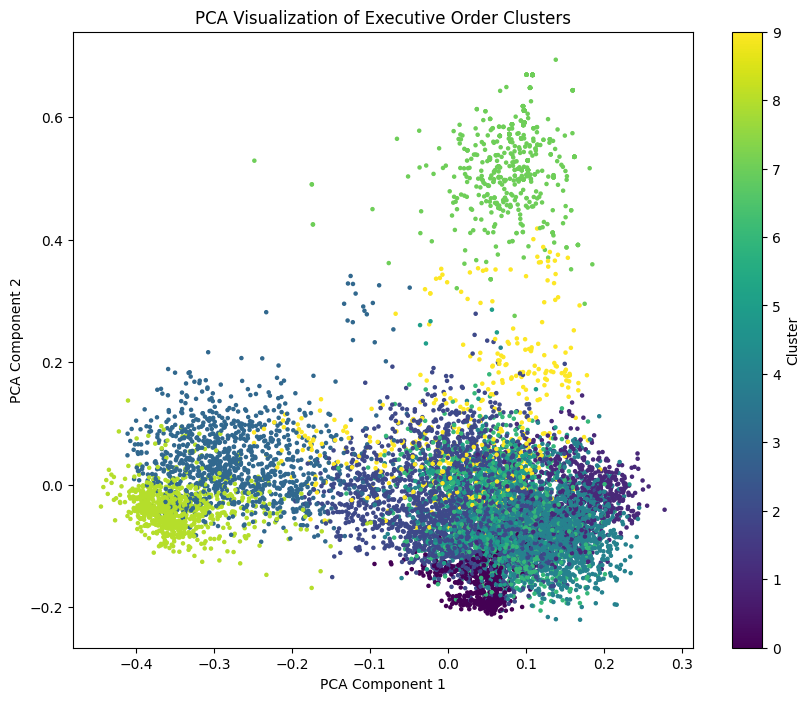

In [52]:
# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_array)

# combine the pca results to the original embeddings_df
embeddings_df['pca1'] = pca_result[:, 0]
embeddings_df['pca2'] = pca_result[:, 1]

# Create a scatter plot of the PCA results, colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Executive Order Clusters')
plt.show()

In [34]:
# find 5 rows close to (-50, 50) and print them
def find_closest_point(x, y, df):
    distances = numpy.sqrt((df['pca1'] - x) ** 2 + (df['pca2'] - y) ** 2)
    closest_points = distances.nsmallest(5).index
    for i in closest_points:
        print(df.iloc[i]['file'])

find_closest_point(-35, 49, embeddings_df)

executive-order-14218-ending-taxpayer-subsidization-open-borders.json
executive-order-12294-suspension-litigation-against-iran.json
executive-order-13183-establishment-the-presidents-task-force-puerto-ricos-status.json
executive-order-keeping-education-accessible-and-ending-covid-19-vaccine-mandates-schools.json
executive-order-13295-revised-list-quarantinable-communicable-diseases.json


In [42]:
embeddings_df[['file', 'cluster', 'pca1', 'pca2']] \
    .sort_values(by=['file']) \
    .to_csv('data/executive_orders/pca.csv', index=False)